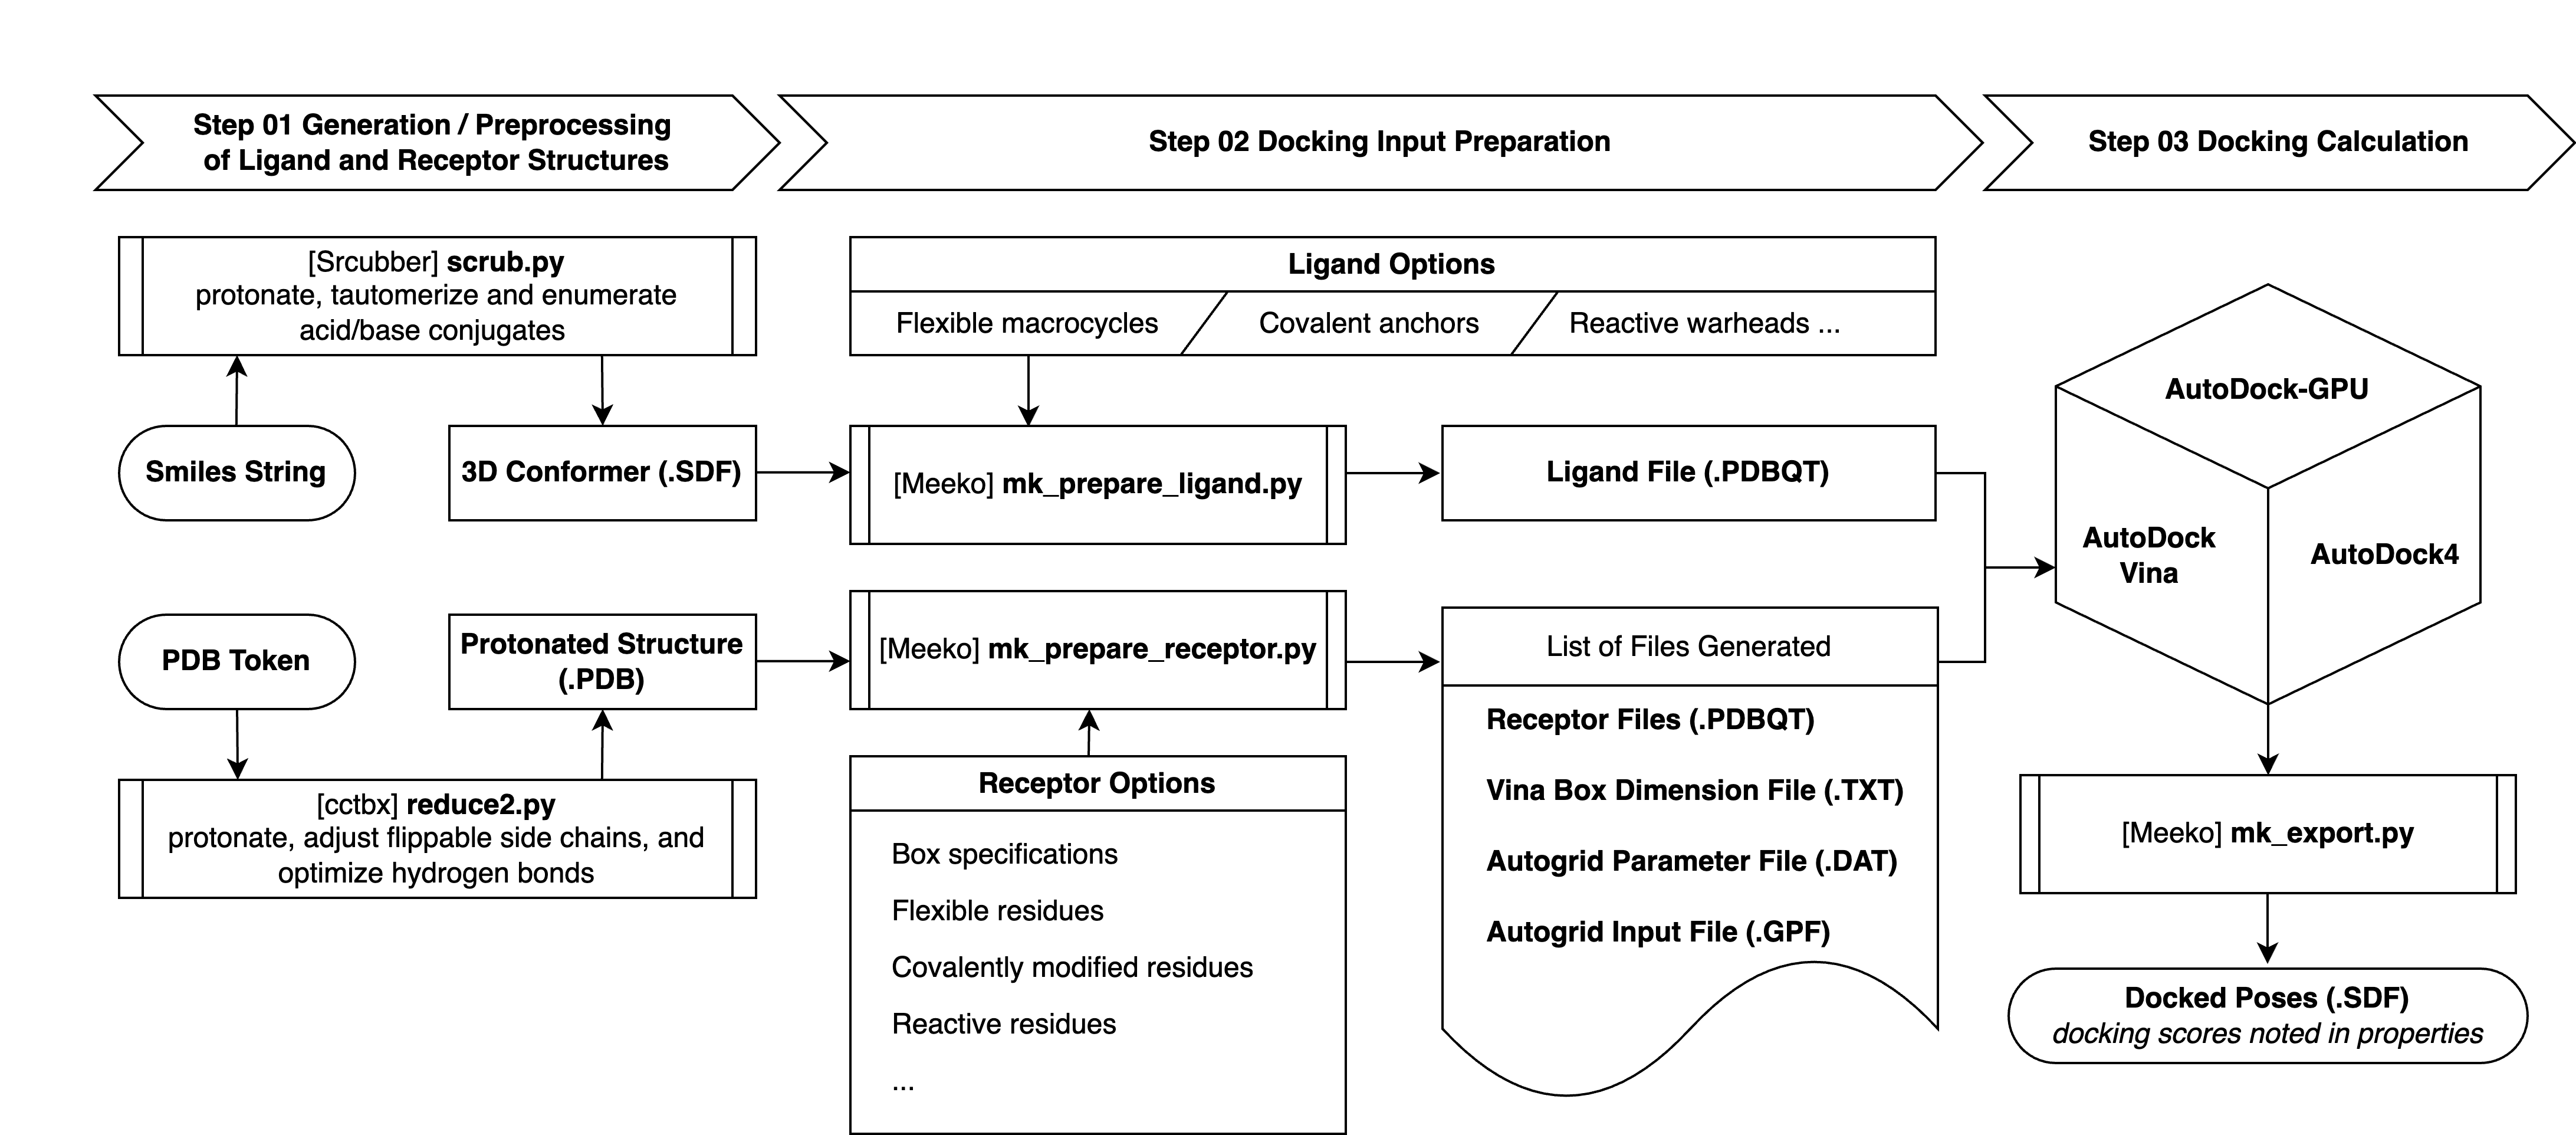

# Overview of This Example: Flexible Docking

> This Colab notebook is currently indexed in:
*   AutoDock-Vina Documentation - [Colab Examples](https://autodock-vina.readthedocs.io/en/latest/colab_examples.html)
*   Meeko Documentation - [Colab Examples](https://meeko.readthedocs.io/en/release-doc/colab_examples.html)
*   RSD3 Training Resource - [Training Resource](https://rsd3.scripps.edu/training/)

This is a **flexible docking** example that uses the AutoDock Vina executable to run a basic docking of a flexible small drug-like molecule onto a protein receptor with flexible residue sidechain(s).

The flexible docking example is a rewrite based on the original flexible docking example. In this example, a variant of Imatinib (PDB token PRC) is docked back to a hollow protein structure of mouse c-Abl (PDB token 1FPU) to reproduce the complex structure. Additionally, Thr315 is set to be a flexible residue. A docked pose that closely resembles the original position of the ligand and **a flipped Thr315** are expected among the top-ranked poses.


# Environment Setup

In these steps, a Python environment is prepared for you to run this example.

*Major Python packages used*

- RDKit https://rdkit.org/
- Molscrub https://github.com/forlilab/molscrub
- Meeko 0.6.1 https://github.com/forlilab/Meeko
- ProDy http://www.bahargroup.org/prody/
- cctbx-base 2024.8 (for reduce2) https://github.com/cctbx/cctbx_project
  - **Note:** The latest version (2025.5) raises an error in this example.
- py3Dmol https://3dmol.org/

*Data*

- Phenix-project/geostd (for reduce2) https://github.com/phenix-project/geostd/

In [ ]:
# Import Modules & Locate Command Line Scripts (< 1s)

# Import modules
from os.path import exists
import sys, platform
from prody import *
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit, py3Dmol
print("rdkit version:", rdkit.__version__)
print("py3Dmol version:", py3Dmol.__version__)
from ipywidgets import interact, IntSlider
import ipywidgets, copy
from IPython.display import display, Markdown


# Helper functions
def locate_file(from_path = None, query_path = None, query_name = "query file"):

    if not from_path or not query_path:
        raise ValueError("Must specify from_path and query_path")

    possible_path = list(from_path.glob(query_path))

    if not possible_path:
        raise FileNotFoundError(f"Cannot find {query_name} from {from_path} by {query_path}")

    return_which = (
        f"using {query_name} at:\n"
        f"{possible_path[0]}\n"
    )
    print(return_which)

    return possible_path[0]


# Commandline scripts
scrub = locate_file(from_path = Path("/opt/conda/envs/vina/bin"), query_path = "scrub.py", query_name = "scrub.py")
mk_prepare_ligand = locate_file(from_path = Path("/opt/conda/envs/vina/bin"), query_path = "mk_prepare_ligand.py", query_name = "mk_prepare_ligand.py")
mk_prepare_receptor = locate_file(from_path = Path("/opt/conda/envs/vina/bin"), query_path = "mk_prepare_receptor.py", query_name = "mk_prepare_receptor.py")
mk_export = locate_file(from_path = Path("/opt/conda/envs/vina/bin"), query_path = "mk_export.py", query_name = "mk_export.py")


# Locate reduce2 in conda install prefix
full_py_version = platform.python_version()
major_and_minor = ".".join(full_py_version.split(".")[:2])
env_path = Path("/opt/conda/envs/vina") # default conda install prefix on Colab
reduce2_path = f"lib/python{major_and_minor}/site-packages/mmtbx/command_line/reduce2.py"
reduce2 = locate_file(from_path = env_path, query_path = reduce2_path, query_name = "reduce2.py")


# Locate geostd in current path
geostd_path = locate_file(from_path = Path.cwd(), query_path = "geostd", query_name = "geostd")

#@markdown > Version of imported modules and the location of command line scripts will be reported to output.
#@markdown >
#@markdown > Make sure there are no errors and proceed to the next code block!


rdkit version: 2025.03.5
py3Dmol version: 2.5.2
using scrub.py at:
/opt/conda/envs/vina/bin/scrub.py

using mk_prepare_ligand.py at:
/opt/conda/envs/vina/bin/mk_prepare_ligand.py

using mk_prepare_receptor.py at:
/opt/conda/envs/vina/bin/mk_prepare_receptor.py

using mk_export.py at:
/opt/conda/envs/vina/bin/mk_export.py

using reduce2.py at:
/opt/conda/envs/vina/lib/python3.10/site-packages/mmtbx/command_line/reduce2.py

using geostd at:
/workspace/geostd



# Docking Calculation

In these steps, the exmaple docking calculation is demonstrated in a customizable setup.

## Major customizable variables

- Ligand Smiles string: `ligand_Smiles`
- Designated pH for ligand preparation: `pH`
- Receptor PDB ID: `pdb_token`
- ProDy selection for receptor atoms: `receptor_selection`
- ProDy selection for box enveloping: `ligand_selection`
- Specification of flexible residues: `flexible_residues`
- Size of box by padding: `padding`
- Exhaustiveness of docking: `exhaustiveness`

## References for setting parameters

- [Atom Selections — ProDy](http://www.bahargroup.org/prody/manual/reference/atomic/select.html)

In [ ]:
# 1.1 Ligand Preparation (< 5s)
# In this step, the ligand molecule is prepared from a Smiles string.
# A protonated 3D conformer of the ligand is generated by **scrub.py**,
# and the conversion to a tangible ligand PDBQT file is done by **mk_prepare_ligand.py**.

# Enter the SMILES string of the ligand.
# This will be used as input for ***molscrub*** to protonate and generate a 3D conformer of the ligand.
ligand_Smiles = "Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4cccnc4" #@param {type:"string"}

# Below are some available options of ***molscrub*** to determine what protonation variants to be generated for the input ligand.

# A designated pH is required.
pH = 6.5 #@param {type:"raw"}
# The following two options allow you to opt out of the enumeration of tautomers or protomers.
# In this example, we will ask ***molscrub*** to perform acid-base enumeration only for the ligand.
args = ""
skip_tautomer = True #@param {type:"boolean"}
if skip_tautomer:
  args += "--skip_tautomer "
skip_acidbase = False #@param {type:"boolean"}
if skip_acidbase:
  args += "--skip_acidbase "
# With the above specifications, a 3D conformer of the protonated ligand will be generated by **scrub.py**.

# The SDF file is then fed to **mk_prepare_ligand.py** to generate the ligand PDBQT file.

# A name for the ligand PDBQT file is required.
ligandName = "PRC"
ligandPDBQT = f"{ligandName}.pdbqt" #@param {type:"string"}


# Write scrubbed protomer(s) and conformer(s) to SDF
ligandSDF = f"{ligandName}_scrubbed.sdf"
! python {scrub} "{ligand_Smiles}" -o {ligandSDF} --ph {pH} {args}


# Prepare ligand PDBQT
! python {mk_prepare_ligand} -i {ligandSDF} -o {ligandPDBQT}


# Visualization with py3Dmol
view = py3Dmol.view()
view.addModel(open(ligandSDF, 'r').read(),'sdf')
view.zoomTo()
view.setBackgroundColor('white')
view.addStyle({'stick': {'colorscheme':'yellowCarbon'}})
view.show()


Scrub completed.
Summary of what happened:
Input molecules supplied: 1
mols processed: 1, skipped by rdkit: 0, failed: 0
nr isomers (tautomers and acid/base conjugates): 1 (avg. 1.000 per mol)
nr conformers:  1 (avg. 1.000 per isomer, 1.000 per mol)
Input molecules processed: 1, skipped: 0
PDBQT files written: 1
PDBQT files not written due to error: 0
Input molecules with errors: 0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# 1.2 Receptor Preparation (< 30s)

# The preparation of a rigid receptor consists of two steps.
# The receptor structure is first sourced from a PDB file and sent to **reduce2.py** for hydrogen addition and optimization,
# and then, the conversion to a tangible receptor PDBQT file is done by **mk_prepare_receptor.py**.

# (1) Add Hydrogens to Receptor with Reduce2

# Enter the PDB ID here to source the starting structure of receptor. This PDB file will be pulled from RCSB PDB server.
# Download PDB file
pdb_token = "1fpu" #@param {type:"string"}
if not exists(f"data/{pdb_token}.pdb"):
    print(f"Downloading {pdb_token}.pdb")
    ! curl "http://files.rcsb.org/view/{pdb_token}.pdb" -o "{pdb_token}.pdb"
else:
    print(f"{pdb_token}.pdb exists")
    ! mv data/{pdb_token}.pdb ./

# Export receptor atoms
atoms_from_pdb = parsePDB(pdb_token)
# Use ProDy selection language to specify atoms to retain in receptor.
receptor_selection = "chain A and not water and not hetero" #@param {type:"string"}
receptor_atoms = atoms_from_pdb.select(receptor_selection)
prody_receptorPDB = f"{pdb_token}_receptor_atoms.pdb"
writePDB(prody_receptorPDB, receptor_atoms)


# Add CRYST1 card (temporarily required for reduce2)
reduce_inputPDB = f"{pdb_token}_receptor.pdb"
! cat <(grep "CRYST1" "{pdb_token}.pdb") {prody_receptorPDB} > {reduce_inputPDB}


# Run reduce2
# Use PHIL arguments to specify the tasks for reduce2. In this example, we use `approach=add add_flip_movers=True` which is equivalent to `-build` or `-flip` in the formerly standalone reduce. These arguments ask ***reduce*** to allow NQH flips and build histidines to neutral tautomers while adding hydrogens.
reduce_opts = "approach=add add_flip_movers=True" #@param {type:"string"}
# ! export MMTBX_CCP4_MONOMER_LIB="{geostd_path}"; python {reduce2} {reduce_inputPDB} {reduce_opts}
! python {reduce2} {reduce_inputPDB} {reduce_opts}
# Default name of reduce output...
prepare_inPDB = f"{pdb_token}_receptorFH.pdb"


# (2) Receptor Preparation with Meeko

# Specify Box
# Center at ligand
atoms_from_pdb = parsePDB(pdb_token)
# Use ProDy selection language to specify (ligand, residue, or any) atoms for box setup. In this example, we choose the ligand and will use a constant padding in each dimension around the ligand to define the box.
ligand_selection = "chain A and resname PRC" #@param {type:"string"}
ligand_atoms = atoms_from_pdb.select(ligand_selection)


# Export ligand's original position to a PDB file. This is entirely optional, but we will do it for visualization purposes.
prody_ligandPDB = "LIG.pdb" #@param {type:"string"}
writePDB(prody_ligandPDB, ligand_atoms)


# Padding in each dimension
# Set the box by the padding range (Å) around the centered object
padding = 8.0 #@param {type:"raw"}


# With the above specifications, atom selection will be made on the original PDB file in ***ProDy***. Then, a protonated structure is generated by **reduce2.py**.

# The PDB file is then fed to **mk_prepare_receptor.py** to generate the receptor PDBQT file.

# Specify the flexible residue(s).
# Flexible (nonreactive) residue
flexible_residues = "A:315" #@param {type:"string"}

# In this example, we will ask Meeko to ignore the few partially resolved residues. When this option is toggled on,
# residues that do not match with the internal chemical templates will be deleted from the receptor structure.
args = ""
allow_bad_res = True #@param {type:"boolean"}
if allow_bad_res:
  args += "--allow_bad_res "

# Prepare Receptor
# A basename for the receptor PDBQT file is required.
prepare_output = "1fpu_receptorFH" #@param {type:"string"}
! python {mk_prepare_receptor} -i {prepare_inPDB} -f {flexible_residues} -o {prepare_output} -p -v -j --box_enveloping {prody_ligandPDB} --padding {padding} {args}


# Visualization with py3Dmol
def Receptor3DView(receptorPDB = None, boxPDB = None, ligPDB = None):

    view = py3Dmol.view()
    view.setBackgroundColor('white')

    view.addModel(open(boxPDB, 'r').read(),'pdb')
    view.addStyle({'stick': {}})
    view.zoomTo()

    view.addModel(open(receptorPDB, 'r').read(),'pdb')
    view.addStyle({'cartoon': {'color':'spectrum', 'opacity': 0.5}})

    if ligPDB is not None:
      view.addModel(open(ligPDB, 'r').read(), 'pdb')
      view.addStyle({'hetflag': True}, {'stick': {}})

    return view

Receptor3DView(receptorPDB = prepare_inPDB, \
               boxPDB = prepare_output + '.box.pdb', \
               ligPDB = prody_ligandPDB).show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  403k    0  403k    0     0  1289k      0 --:--:-- --:--:-- --:--:-- 1289k


@> PDB file is found in working directory (1fpu.pdb).
@> 4451 atoms and 1 coordinate set(s) were parsed in 0.07s.


Starting /opt/conda/envs/vina/lib/python3.10/site-packages/mmtbx/command_line/reduce2.py
on Fri Aug 29 10:11:53 2025 by root

Processing files:
-------------------------------------------------------------------------------

  Found model, 1fpu_receptor.pdb

Processing PHIL parameters:
-------------------------------------------------------------------------------

  Adding command-line PHIL:
  -------------------------
    approach=add
    add_flip_movers=True

Final processed PHIL parameters:
-------------------------------------------------------------------------------
  data_manager {
    model {
      file = "1fpu_receptor.pdb"
    }
    default_model = "1fpu_receptor.pdb"
  }
  add_flip_movers = True


Starting job
Writing model output to 1fpu_receptorFH.pdb

                       ----------Loading Model----------                       


                      ----------Adding Hydrogens----------                     

Number of hydrogen atoms added to the input model: 2027 


T

@> PDB file is found in working directory (1fpu.pdb).
@> 4451 atoms and 1 coordinate set(s) were parsed in 0.04s.


In [5]:
# 2. Docking with Vina Scoring Function (~ 3min)

# In this step, the docking calculation is executed by ***Vina***.

# Specify the names of inputs. You may include any additional options in `configTXT`.
rigid_receptorPDBQT = "1fpu_receptorFH_rigid.pdbqt" #@param {type:"string"}
flex_receptorPDBQT = "1fpu_receptorFH_flex.pdbqt" #@param {type:"string"}
ligandPDBQT = "PRC.pdbqt" #@param {type:"string"}
configTXT = "1fpu_receptorFH.box.txt" #@param {type:"string"}
# Specify the exhaustiveness of docking.
# In this example, we use a relatively low `exhaustiveness = 8` for demonstration purposes.
exhaustiveness = 8 #@param {type:"raw"}
# A name for the docking output PDBQT file is required.
outputPDBQT = "1fpu_PRC_vina_out.pdbqt" #@param {type:"string"}

! vina --receptor {rigid_receptorPDBQT} --flex {flex_receptorPDBQT} --ligand {ligandPDBQT} --config {configTXT} \
       --exhaustiveness {exhaustiveness} \
       --out {outputPDBQT}

AutoDock Vina 23d1252-mod
#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# J. Eberhardt, D. Santos-Martins, A. F. Tillack, and S. Forli  #
# AutoDock Vina 1.2.0: New Docking Methods, Expanded Force      #
# Field, and Python Bindings, J. Chem. Inf. Model. (2021)       #
# DOI 10.1021/acs.jcim.1c00203                                  #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, J. Comp. Chem. (2010)                         #
# DOI 10.1002/jcc.21334                                         #
#                                                               #
# Please see https://github.com/ccsb-scripps/AutoD

In [ ]:
# 3. Export and Visualize Docked Poses (~ 1s)

# In this step, the docking output is converted to atomistic SDF by **mk_export.py**.

# Export Docked Poses
# A name for the result SDF file is required.
dock_outSDF = "1fpu_PRC_vina_out.sdf" #@param {type:"string"}
# Additionally, with a receptor JSON file generated during receptor preparation, an output PDB with updated receptor structures can be generated.
dock_outPDB = "1fpu_PRC_vina_out.pdb" #@param {type:"string"}
receptor_JSON = prepare_output+".json"
! python {mk_export} {outputPDBQT} -s {dock_outSDF} -j {receptor_JSON}

# Finally (and optionally) for visualization:

# The ***Py3DMol*** view will include object from the following files and specs:
# Previously Generated Receptor Files
receptorPDB = "1fpu_receptorFH.pdb" #@param {type:"string"}
boxPDB = "1fpu_receptorFH.box.pdb" #@param {type:"string"}
refligPDB = 'LIG.pdb' #@param {type:"string"}
reflig_resn = 'PRC' #@param {type:"string"}

# Visualize Docked Poses
def Complex3DView(view, ligmol = None, refligPDB = None, reflig_resn = None):

    new_viewer = copy.deepcopy(view)

    mblock = Chem.MolToMolBlock(ligmol)
    new_viewer.addModel(mblock, 'mol')
    new_viewer.addStyle({'hetflag': True}, {"stick": {'colorscheme': 'greenCarbon'}})

    if refligPDB is not None and reflig_resn is not None:
      new_viewer.addModel(open(refligPDB, 'r').read(), 'pdb')
      new_viewer.addStyle({'resn': reflig_resn}, {"stick": {'colorscheme': 'magentaCarbon', 'opacity': 0.8}})

    return new_viewer


confs = Chem.SDMolSupplier(dock_outSDF)

def conf_viewer(idx):
    mol = confs[idx]
    return Complex3DView(Receptor3DView(receptorPDB = receptorPDB, boxPDB = boxPDB), \
                         mol, \
                         refligPDB = refligPDB, reflig_resn = reflig_resn).show()


interact(conf_viewer, idx=ipywidgets.IntSlider(min=0, max=len(confs)-1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=8), Output()), _dom_classes=('widget-interact'…

<function __main__.conf_viewer(idx)>

In [ ]:
# Move results files into results/ directory
! mv {pdb_token}.pdb data/
! mv {pdb_token}* results/
! mv {ligandName}* results/
! mv LIG.pdb results/